# Dequantization

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

sys.path.insert(1, '../src/')
import concrete
import gibbs

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})

## 1D toy problem

In [8]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb
prbs_onedim=np.copy(prbs)

In [10]:
########################
########################
#    Gibbs sampling    #
########################
########################

np.random.seed(2023)
gibbs_ss=5000
x0=np.random.randint(low=0,high=K1)*np.ones(1)

gibbs_samples_onedim=gibbs.gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.25,verbose=True) #(K1,gibbs_ss)

In [4]:
def create_dequant_RealNVP(dim,depth,width):
    """
    Wrapper to init a RealNVP flow for a dequantization problem
    with dimension dim that consists of depth layers

    The reference distribution is an isotropic Gaussian

    Inputs:
        dim   : int, dimension of data
        depth : int, number of couplings (transformations)
        width : int, width of the linear layers

    Outputs:
        flow   : Module, RealNVP
    """

    # create channel-wise masks of appropriate size
    masks=torch.zeros((2,dim))
    masks[0,:(dim//2)]=1
    masks[1,(dim-(dim//2)):]=1
    masks=masks.repeat(depth//2,1)

    # define reference distribution
    ref = torch.distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))

    # define scale and translation architectures
    net_s = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim),
        nn.Tanh()
    )
    net_t = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim)
    )
    return concrete.RealNVP(net_s, net_t, masks, ref)

In [24]:
def train_dequant_discrete(depth,sample,width=32,max_iters=1000,lr=1e-4,seed=0,verbose=True):
    """
    Train a dequantized RealNVP normalizing flow using the Adam optimizer

    Input:
        depth     : int, number of couplings (transformations)
        sample    : (dim,B) array, quantized sample from target (e.g., from Gibbs sampler)
        width     : int, width of the linear layers
        max_iters : int, max number of Adam iters
        lr        : float, Adam learning rate
        
        seed      : int, for reproducinility
        verbose   : boolean, indicating whether to print loss every 100 iterations of Adam
    """
    torch.manual_seed(seed)

    # create flow
    dim,B = sample.shape
    flow = create_dequant_RealNVP(dim,depth,width)

    # dequantize sample
    training_sample = torch.from_numpy(sample.T) + torch.rand(B,dim)
    
    # train flow
    optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr)
    losses=np.zeros(max_iters)

    for t in range(max_iters):
        loss = -flow.log_prob(training_sample).mean()
        losses[t]=loss

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if verbose and t%(max_iters//10) == 0: print('iter %s:' % t, 'loss = %.3f' % loss)
    # end for
    return flow,losses

In [76]:
tt_samples = gibbs_samples_onedim + np.random.rand(1,gibbs_ss)
tt_samples = np.floor(np.squeeze(tt_samples)).astype(int)
tt_samples_density = plt.hist(tt_samples,density=True,bins=np.arange(0,K1+1))[0];
plt.clf()

<Figure size 1500x750 with 0 Axes>

(0.0, 0.25)

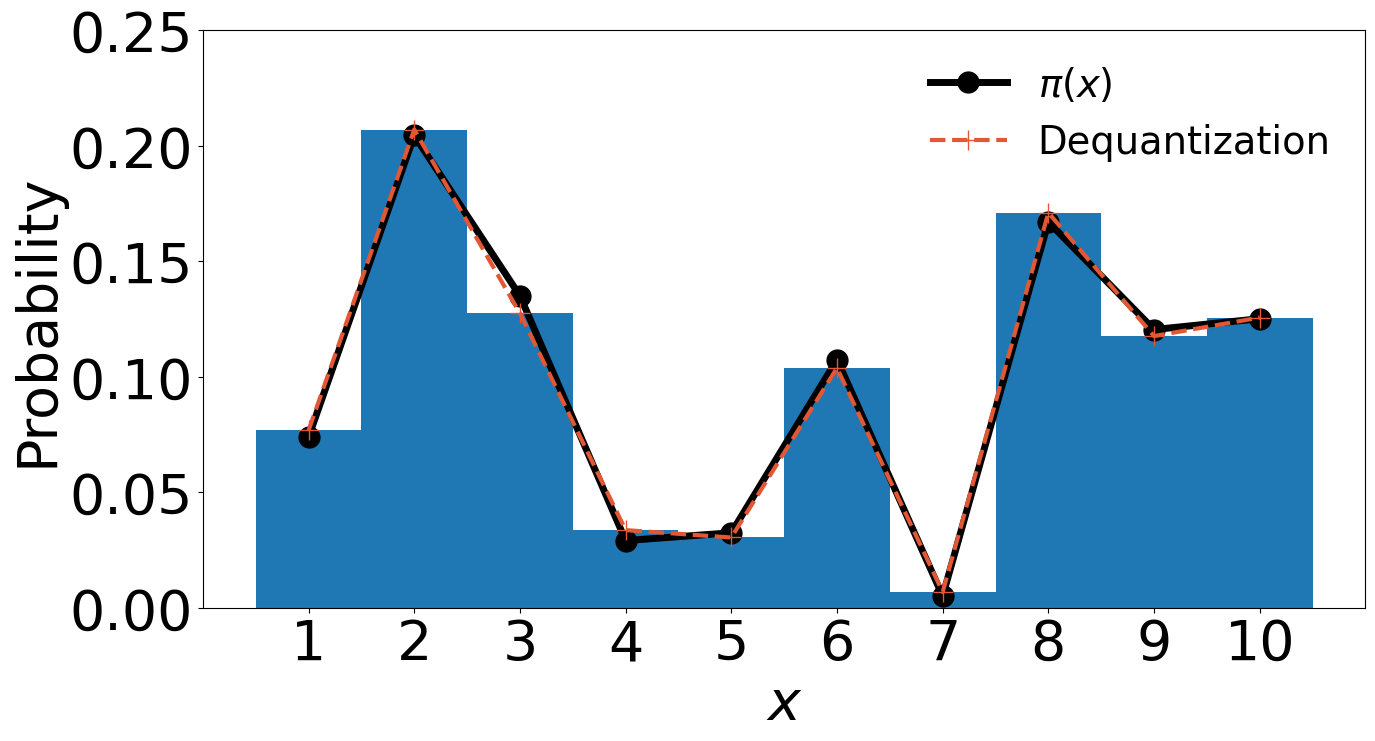

In [78]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,10)
plt.plot(ttx+0.5,prbs_onedim,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,tt_samples_density,c='#E25734', label='Dequantization',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='x-small',frameon=False)
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,10)+0.5,labels=np.arange(1,1+10))
plt.ylabel('Probability')
plt.ylim(0,0.25)

In [67]:
########################
########################
#    dequantization    #
########################
########################

# settings
depth = 50
sample = gibbs_samples_onedim
width = 32
max_iters = 201
lr = 1e-2

tt_f,tt_l=train_dequant_discrete(depth,sample,width,max_iters,lr)

iter 0: loss = 422.751
iter 100: loss = 2.580
iter 200: loss = 2.578
iter 300: loss = 2.578
iter 400: loss = 2.578
iter 500: loss = 2.578
iter 600: loss = 2.578
iter 700: loss = 2.580
iter 800: loss = 2.578
iter 900: loss = 2.578


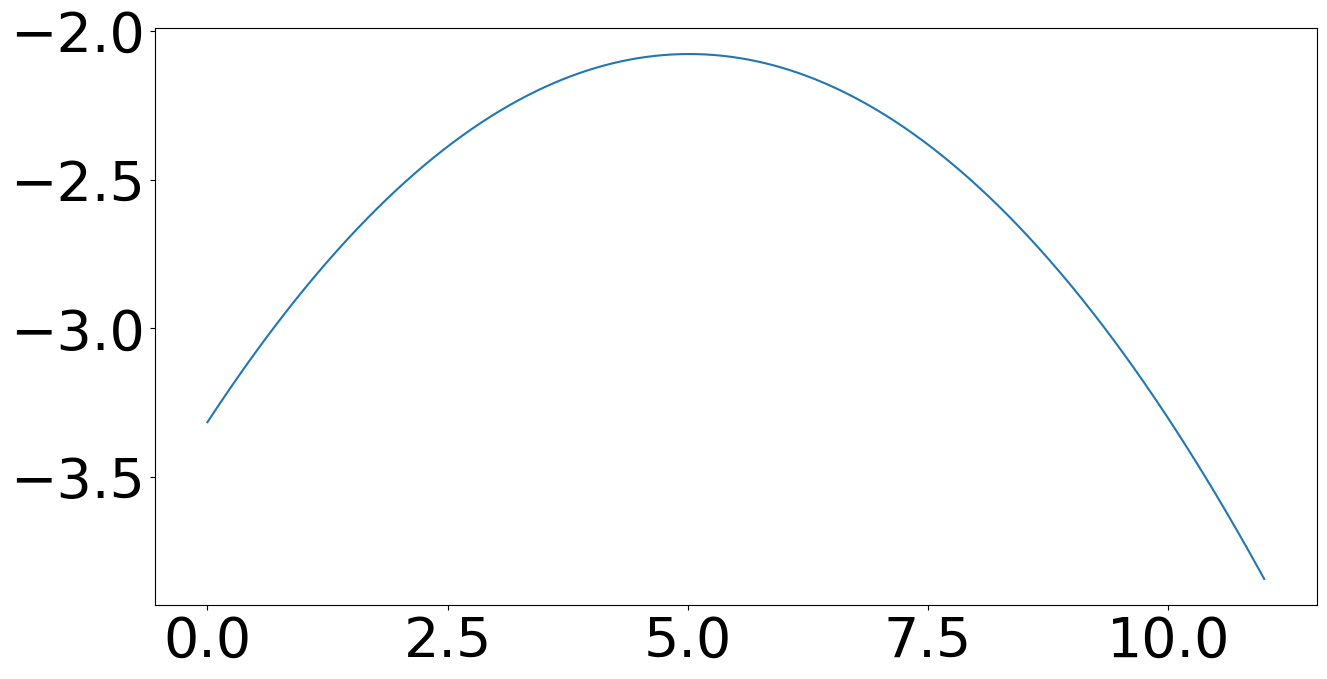

In [68]:
x_ls = torch.linspace(0,K1+1,steps=1000)
plt.plot(x_ls,tt_f.log_prob(x_ls[:,None]).detach().numpy())

In [69]:
dequant_samples = np.squeeze(tt_f.sample(10000).detach().numpy())
dequant_samples = np.floor(dequant_samples).astype(int) # round to get sample
dequant_density_onedim = plt.hist(dequant_samples,density=True,bins=np.arange(0,K1+1))[0];
plt.clf()

<Figure size 1500x750 with 0 Axes>

(0.0, 0.25)

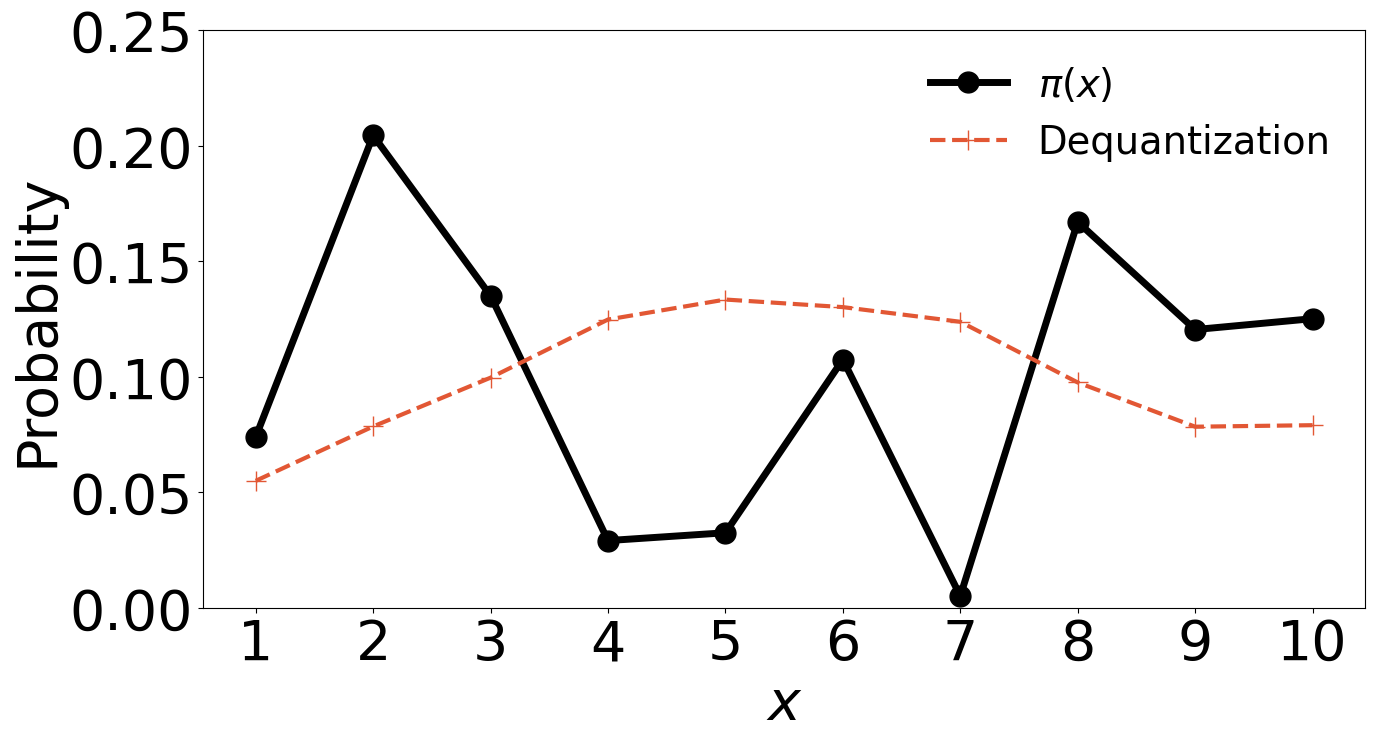

In [70]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,10)
plt.plot(ttx+0.5,prbs_onedim,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,dequant_density_onedim,c='#E25734', label='Dequantization',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='x-small',frameon=False)
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,10)+0.5,labels=np.arange(1,1+10))
plt.ylabel('Probability')
plt.ylim(0,0.25)